In [22]:
import keras
from keras.layers import Conv2D, Conv3D, MaxPool3D, MaxPool2D, concatenate, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils import plot_model


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [0]:
data = sio.loadmat('/content/Indian_pines_corrected.mat')['indian_pines_corrected']
labels = sio.loadmat('/content/Indian_pines_gt.mat')['indian_pines_gt']

In [0]:
test_ratio = 0.9
windowSize = 25

In [0]:
def TrainTestSplit(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [0]:
def dim_reduce_PCA(X, numComponents):
    dim_reduce_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    dim_reduce_X = pca.fit_transform(dim_reduce_X)
    dim_reduce_X = np.reshape(dim_reduce_X, (X.shape[0],X.shape[1], numComponents))
    return dim_reduce_X, pca

In [0]:
def ZeroPadding(X, border_offset=2):
    ZeroPadding_X = np.zeros((X.shape[0] + 2 *(border_offset), X.shape[1] + 2*(border_offset), X.shape[2]))
    x_offset = border_offset
    y_offset = border_offset
    ZeroPadding_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return ZeroPadding_X

In [0]:
def PixelwiseInput(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    ZeroPadding_X = ZeroPadding(X, border_offset=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, ZeroPadding_X.shape[0] - margin):
        for c in range(margin, ZeroPadding_X.shape[1] - margin):
            patch = ZeroPadding_X[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
X = data
y = labels

In [0]:
K=30
X,pca = dim_reduce_PCA(X,numComponents=K)

In [0]:
X, y = PixelwiseInput(X, y, windowSize=windowSize)

In [0]:
Xtrain, Xtest, ytrain, ytest = TrainTestSplit(X, y, test_ratio)

In [0]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, 30 , 1)

In [0]:
ytrain = np_utils.to_categorical(ytrain)

In [0]:
S = windowSize
L = K
output_units = 16

In [0]:
def inception_module_3d(input_layer,
                     filters_1x1x1,
                     filters_3x3x3_reduce,
                     filters_3x3x3,
                     filters_3x3x5_reduce,
                     filters_3x3x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1x1 = Conv3D(filters_1x1x1, (1, 1, 1), padding='same', activation='relu')(input_layer)
    
    conv_3x3x3 = Conv3D(filters_3x3x3_reduce, (1, 1, 1), padding='same', activation='relu')(input_layer)
    conv_3x3x3 = Conv3D(filters_3x3x3, (3, 3, 3), padding='same', activation='relu')(conv_3x3x3)

    conv_3x3x5 = Conv3D(filters_3x3x5_reduce, (1, 1, 1), padding='same', activation='relu')(input_layer)
    conv_3x3x5 = Conv3D(filters_3x3x5, (3, 3, 5), padding='same', activation='relu')(conv_3x3x5)

    pool_proj = MaxPool3D((3, 3, 3), strides=(1, 1, 1), padding='same')(input_layer)
    pool_proj = Conv3D(filters_pool_proj, (1, 1, 1), padding='same', activation='relu')(pool_proj)

    output_3d = concatenate([conv_1x1x1, conv_3x3x3, conv_3x3x5, pool_proj], axis=4, name=name)
    
    return output_3d

In [0]:
def inception_module_2d(x,
                     filters_1x1,
                     filters_2x2_reduce,
                     filters_2x2,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_2x2 = Conv2D(filters_2x2_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_2x2 = Conv2D(filters_2x2, (2, 2), padding='same', activation='relu')(conv_2x2)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_2x2, conv_3x3, pool_proj], axis=3, name=name)
    
    return output

In [0]:
## Input layer
input_layer = Input((S, S, L, 1))


## Inception layers (for 3D convolution)
inception_1 = inception_module_3d(input_layer,32,48,64,8,16,16)
inception_2 = inception_module_3d(inception_1,32,48,64,8,16,16)

inception_2_shape = inception_2._keras_shape

#Inception 2D convolution
reshape_1 = Reshape((inception_2_shape[1], inception_2_shape[2], inception_2_shape[3]*inception_2_shape[4]))(inception_2)
conv_2 = inception_module_2d(reshape_1,64,64,96,16,48,32)

flatten_1 = Flatten()(conv_2)

## Dense FC Layer
dense_1 = Dense(units=256, activation='relu')(flatten_1)
dense_1 = Dropout(0.4)(dense_1)
dense_2 = Dense(units=128, activation='relu')(dense_1)
dense_2 = Dropout(0.4)(dense_2)
output_layer = Dense(units=16, activation='softmax')(dense_2)

In [39]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 25, 30, 1 0                                            
__________________________________________________________________________________________________
conv3d_14 (Conv3D)              (None, 25, 25, 30, 4 96          input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_16 (Conv3D)              (None, 25, 25, 30, 8 16          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_3 (MaxPooling3D)  (None, 25, 25, 30, 1 0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
# checkpoint
filepath = "/content/best-modelindian_pines.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [42]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=70, callbacks=callbacks_list)

Epoch 1/70
1024/1024 [==============================] - 34s 34ms/step - loss: 3.4072 - accuracy: 0.1553
Epoch 2/70


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning:

Can save best model only with acc available, skipping.



1024/1024 [==============================] - 33s 32ms/step - loss: 2.2721 - accuracy: 0.2646
Epoch 3/70
1024/1024 [==============================] - 33s 32ms/step - loss: 1.8472 - accuracy: 0.3906
Epoch 4/70
1024/1024 [==============================] - 33s 32ms/step - loss: 1.3379 - accuracy: 0.5684
Epoch 5/70
1024/1024 [==============================] - 33s 32ms/step - loss: 0.9277 - accuracy: 0.7090
Epoch 6/70
1024/1024 [==============================] - 33s 32ms/step - loss: 0.6619 - accuracy: 0.7949
Epoch 7/70
1024/1024 [==============================] - 33s 32ms/step - loss: 0.4503 - accuracy: 0.8574
Epoch 8/70
1024/1024 [==============================] - 33s 32ms/step - loss: 0.3602 - accuracy: 0.8877
Epoch 9/70
1024/1024 [==============================] - 33s 32ms/step - loss: 0.3402 - accuracy: 0.8955
Epoch 10/70
1024/1024 [==============================] - 33s 32ms/step - loss: 0.2437 - accuracy: 0.9268
Epoch 11/70
1024/1024 [==============================] - 33s 32ms/step - l

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [44]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(9225, 25, 25, 30, 1)

In [45]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(9225, 16)

In [46]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        41
           1       0.97      0.94      0.95      1285
           2       0.99      0.97      0.98       747
           3       0.92      0.94      0.93       213
           4       1.00      0.98      0.99       435
           5       0.98      1.00      0.99       657
           6       1.00      0.96      0.98        25
           7       0.98      1.00      0.99       430
           8       1.00      0.83      0.91        18
           9       0.97      0.99      0.98       875
          10       0.97      1.00      0.98      2210
          11       0.99      0.92      0.96       534
          12       1.00      0.99      1.00       185
          13       1.00      1.00      1.00      1139
          14       1.00      0.95      0.97       347
          15       0.86      0.99      0.92        84

    accuracy                           0.98      9225
   macro avg       0.97   

In [0]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [0]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
   
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [57]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report_ip10.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

9225/9225 [==============================] - 88s 10ms/step


In [0]:

def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch


In [0]:
X = sio.loadmat('/content/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [0]:
X,pca = dim_reduce_PCA(X, numComponents=numComponents)

In [0]:

X = ZeroPadding(X, PATCH_SIZE//2)

In [0]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

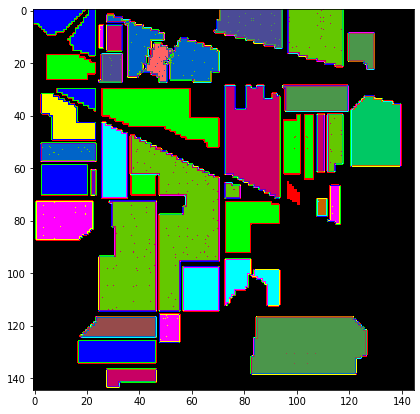

In [55]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

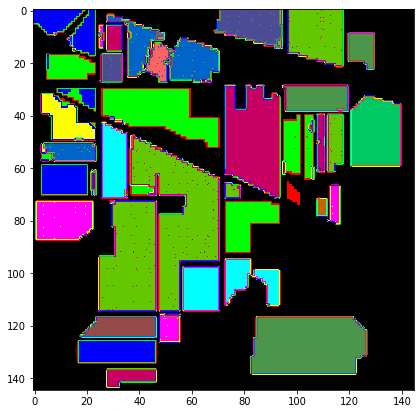

In [56]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))